In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

In [18]:
def setup_dataframes():
    df = pd.read_csv('MM_game_data.csv')
    df = df[df['YEAR'] >= 2013]
    df = df[df['YEAR'] <= 2023]
    np.unique(df['YEAR'])
    games = df.drop(['ROUND'], axis=1)
    
    df = pd.read_csv('cbb.csv')
    df = df[df['SEED'] > 0]
    df = df[df['YEAR'] <= 2023]
    teams = df.drop(['CONF', 'POSTSEASON', 'SEED'], axis=1)
    
    rv = np.floor(np.random.rand(len(games))*2)
    
    return (games,teams,rv)

In [3]:
def get_team_data(team, year):
    all_years = teams.loc[teams['TEAM'] == team]
    specific_year = all_years.loc[all_years['YEAR'] == year]
    return specific_year

In [4]:
def assemble_game_data():
    game_data = np.zeros(shape=(len(games), 38))
    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        if rv[i] == 0:
            game_data[i] = np.hstack([wdata, ldata])
        else:
            game_data[i] = np.hstack([ldata, wdata])
    return game_data

In [5]:
def assemble_response_data():
    score_diff = []
    for i in range(0,len(games)):
        if rv[i] == 0:
            score_diff.append(games.iloc[i]['WSCORE'] - games.iloc[i]['LSCORE'])
        else:
            score_diff.append(games.iloc[i]['LSCORE'] - games.iloc[i]['WSCORE'])
    return score_diff

In [6]:
def get_invalid_team_names():
    wrong_names = []

    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR'])
        if wdata.empty:
            wrong_names.append(games.iloc[i]['WTEAM'])
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR'])
        if ldata.empty:
            wrong_names.append(games.iloc[i]['LTEAM'])
    return np.unique(wrong_names)

In [148]:
def process_bracket(model):
    numlist = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
    df = pd.read_csv('2023bracket.csv')
    
    FF = first_four_winners(df, model) 
    
    south = [None] * 16
    east = [None] * 16
    midwest = [None] * 16
    west = [None] * 16
    
    for i in range(16):
        if i == 15:
            south[numlist.index(i+1)] = FF[0]
            east[numlist.index(i+1)] = FF[1]
        else:
            southdata = df.loc[(df['Division'] == 'South') & (df['Seed'] == str(i+1))]
            south[numlist.index(i+1)] = str(southdata.iloc[0]['Team'])
            eastdata = df.loc[(df['Division'] == 'East') & (df['Seed'] == str(i+1))]
            east[numlist.index(i+1)] = str(eastdata.iloc[0]['Team'])
        if i == 10:
            midwest[numlist.index(i+1)] = FF[2]
            west[numlist.index(i+1)] = FF[3]
        else:
            midwestdata = df.loc[(df['Division'] == 'Midwest') & (df['Seed'] == str(i+1))]
            midwest[numlist.index(i+1)] = str(midwestdata.iloc[0]['Team'])
            westdata = df.loc[(df['Division'] == 'West') & (df['Seed'] == str(i+1))]
            west[numlist.index(i+1)] = str(westdata.iloc[0]['Team'])
            
        
    print(south)
    print(east)
    print(midwest)
    print(west)
    
    return        
    

In [93]:
def first_four_winners(df, model):
    FF = []
    for index, row in df[df['Seed'] == 'FF'].iterrows():
        FF.append(row['Team'])
    FFgames = []
    for i in range(int(len(FF)/2)):
        team1 = get_team_data(FF[2*i], 2023).drop(['TEAM', 'YEAR'], axis=1)
        team2 = get_team_data(FF[2*i+1], 2023).drop(['TEAM', 'YEAR'], axis=1)
        FFgames.append(np.hstack([team1, team2]))
    
    FFwinners = []
    for i in range(len(FFgames)):
        prob = model(FFgames[i])[:,1]
        if prob > 0.5:
            FFwinners.append(FF[2*i])
        else:
            FFwinners.append(FF[2*i+1])
    return FFwinners

In [21]:
(games,teams,rv) = setup_dataframes()

In [8]:
game_data = assemble_game_data()
score_data = assemble_response_data()
X_train, X_test, y_train, y_test = train_test_split(game_data, score_data, test_size=0.2, random_state=1)

0.47106069618262403

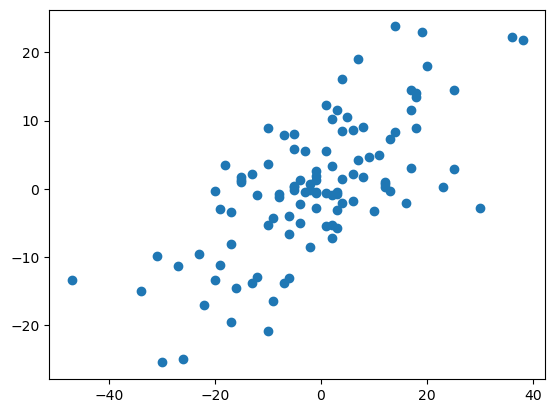

In [9]:
regr = MLPRegressor(random_state=1).fit(X_train, y_train)

pred = regr.predict(X_test)
plt.scatter(y_test, pred)
regr.score(X_test, y_test)

In [10]:
win_data = (np.sign(score_data) + 1)/2

In [62]:
layers = [tf.keras.Input(shape=(None,38)), Dense(1000, activation="relu"), Dropout(0.1), Dense(500, activation="relu"), Dropout(0.2), Dense(250, activation="relu"), Dense(2, activation="softmax")]
model = tf.keras.models.Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 1000)        39000     
                                                                 
 dropout_2 (Dropout)         (None, None, 1000)        0         
                                                                 
 dense_5 (Dense)             (None, None, 500)         500500    
                                                                 
 dropout_3 (Dropout)         (None, None, 500)         0         
                                                                 
 dense_6 (Dense)             (None, None, 250)         125250    
                                                                 
 dense_7 (Dense)             (None, None, 2)           502       
                                                                 
Total params: 665252 (2.54 MB)
Trainable params: 66525

In [63]:
n_epochs = 50
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(game_data, win_data, epochs=n_epochs)

Epoch 1/50
17/17 [==============================] - 1s 10ms/step - loss: 9.7074 - accuracy: 0.4991
Epoch 2/50
17/17 [==============================] - 0s 12ms/step - loss: 0.9934 - accuracy: 0.5458
Epoch 3/50
17/17 [==============================] - 0s 14ms/step - loss: 0.8433 - accuracy: 0.5421
Epoch 4/50
17/17 [==============================] - 0s 14ms/step - loss: 0.7709 - accuracy: 0.6075
Epoch 5/50
17/17 [==============================] - 0s 14ms/step - loss: 0.7011 - accuracy: 0.6280
Epoch 6/50
17/17 [==============================] - 0s 13ms/step - loss: 0.6622 - accuracy: 0.6673
Epoch 7/50
17/17 [==============================] - 0s 13ms/step - loss: 0.6622 - accuracy: 0.6430
Epoch 8/50
17/17 [==============================] - 0s 12ms/step - loss: 0.6338 - accuracy: 0.6766
Epoch 9/50
17/17 [==============================] - 0s 10ms/step - loss: 0.6309 - accuracy: 0.6804
Epoch 10/50
17/17 [==============================] - 0s 9ms/step - loss: 0.5511 - accuracy: 0.7196
Epoch 11/5

In [64]:
pred = model(game_data)
#confusion_matrix(win_data, pred)
confusion_matrix(win_data, np.round(pred[:,1]))

array([[213,  56],
       [ 63, 203]], dtype=int64)

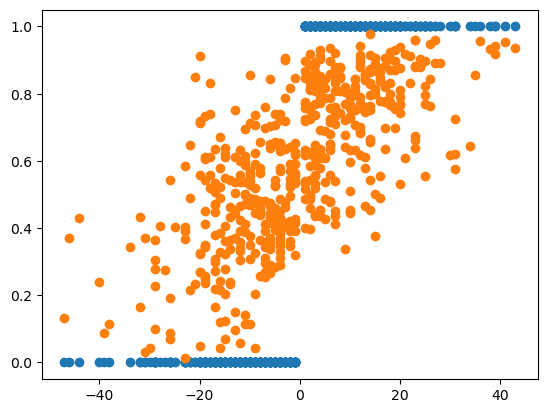

In [15]:
plt.scatter(score_data, win_data)
plt.scatter(score_data, pred[:,1])

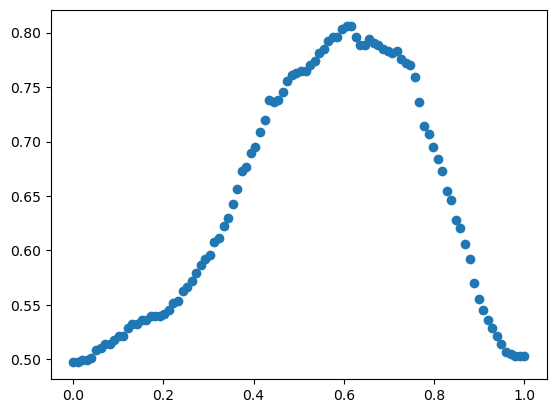

In [16]:
cutoffs = np.linspace(0, 1, 100)
accuracies = []
for cutoff in cutoffs:
    pred1 = np.ceil(pred[:,1] - cutoff)
    accuracies.append(accuracy_score(win_data, pred1))
    
plt.scatter(cutoffs, accuracies)

In [149]:
process_bracket(model)

['Alabama', 'Texas A&M Corpus Chris', 'Maryland', 'West Virginia', 'San Diego St.', 'College of Charleston', 'Virginia', 'Furman', 'Creighton', 'NC State', 'Baylor', 'UC Santa Barbara', 'Missouri', 'Utah St.', 'Arizona', 'Princeton']
['Purdue', 'Fairleigh Dickinson', 'Memphis', 'Florida Atlantic', 'Duke', 'Oral Roberts', 'Tennessee', 'Louisiana', 'Kentucky', 'Providence', 'Kansas St.', 'Montana St.', 'Michigan St.', 'USC', 'Marquette', 'Vermont']
['Houston', 'Northern Kentucky', 'Iowa', 'Auburn', 'Miami FL', 'Drake', 'Indiana', 'Kent St.', 'Iowa St.', 'Pittsburgh', 'Xavier', 'Kennesaw St.', 'Texas A&M', 'Penn St.', 'Texas', 'Colgate']
['Kansas', 'Howard', 'Arkansas', 'Illinois', "Saint Mary's", 'VCU', 'Uconn', 'Iona', 'TCU', 'Arizona St.', 'Gonzaga', 'Grand Canyon', 'Northwestern', 'Boise St.', 'UCLA', 'UNC Asheville']
